In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import torch
import torch.nn as nn
from Autoencoder import *
from dataprocess import *
from train import *
%reload_ext autoreload
%autoreload 2


Question 1

In [3]:
# run to train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


file_path = './data/VBOX.csv'
data = load_data(file_path)

# spilt the data
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

# set the T and process data
T = 10  # 1s
train_data, test_data = switch_data(train_data, T), switch_data(test_data, T)
train_data, test_data = torch.tensor(train_data, dtype=torch.float32).to(device), torch.tensor(test_data, dtype=torch.float32).to(device)
input_dimension = train_data.shape[-1]
hidden_dimension = input_dimension // 2
print(f"train data size is: {train_data.shape}", "\n", f"test data size is{test_data.shape}", "\n", f"the data class is{type(train_data)}")


#----------------------------------------------------------------------------------
# encoder = Encoder(input_dimension, hidden_dimension).to(device)                  
# encoder_output = encoder(train_data[0:32, :, :])
# print(encoder_output)

# decoder = Decoder(hidden_dimension, input_dimension).to(device)
# decoder_output = decoder(encoder_output, encoder_output, encoder_output)
# print(f"decoder_output size is:{decoder_output.shape}")
# print(decoder_output)
#-----------------------------------------------------------------------------------



# 创建数据加载器
train_dataset = TensorDataset(train_data)
test_dataset = TensorDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 创建模型
num_layers = 2
autoencoder = AutoEncoder(input_dimension, hidden_dimension, num_layers).to(device)

# 训练模型
# train_model(autoencoder, train_loader, device, num_epochs=300)


model_state_dict = torch.load('./exp/best_model.pth')  # 将训练好的模型参数赋给实例
if 'model' in model_state_dict.keys():
    model_state_dict = model_state_dict['model']
autoencoder.load_state_dict(model_state_dict)


train data size is: torch.Size([4639, 10, 13]) 
 test data size istorch.Size([515, 10, 13]) 
 the data class is<class 'torch.Tensor'>


<All keys matched successfully>

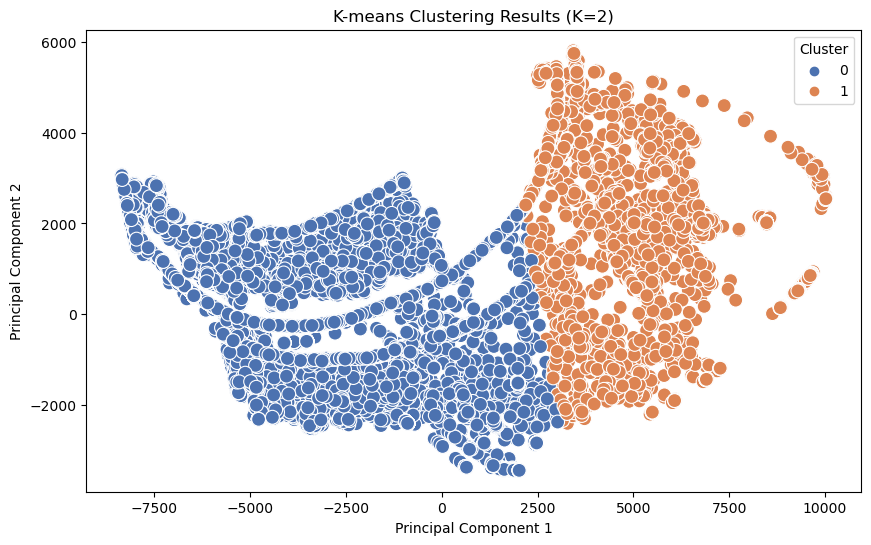

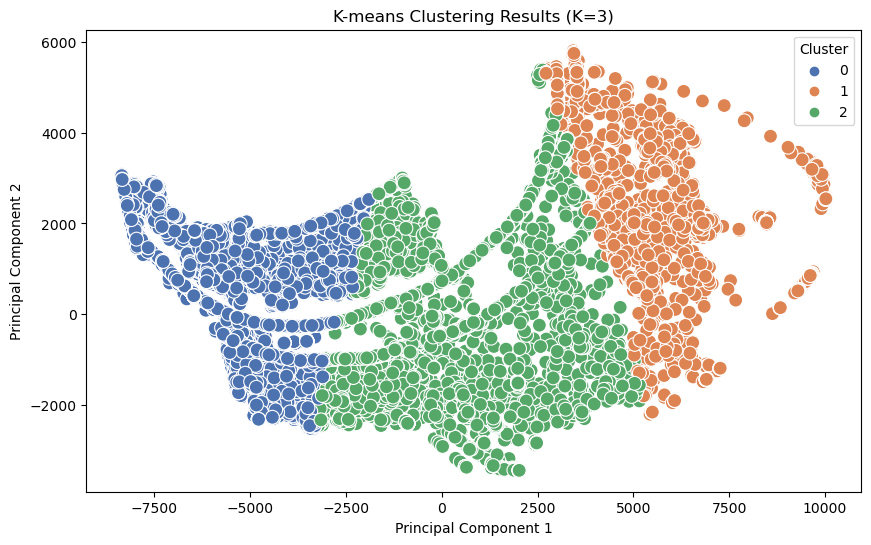

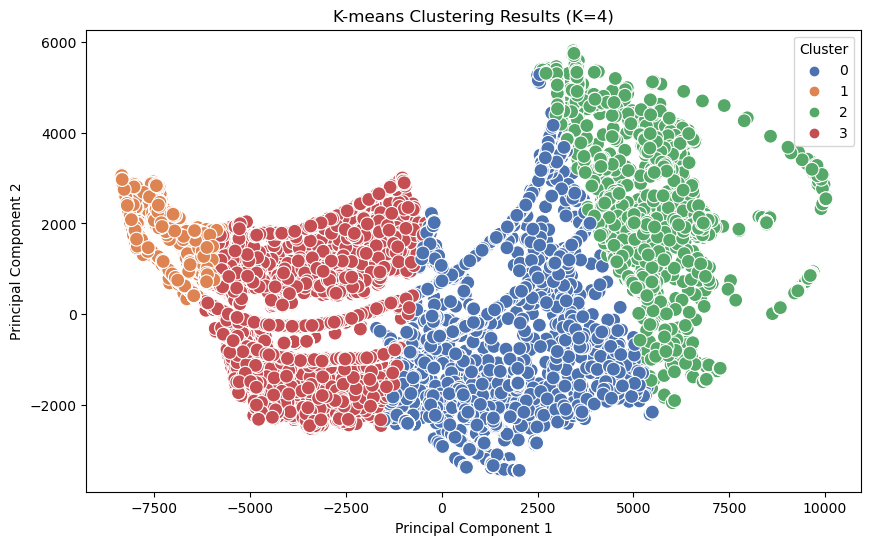

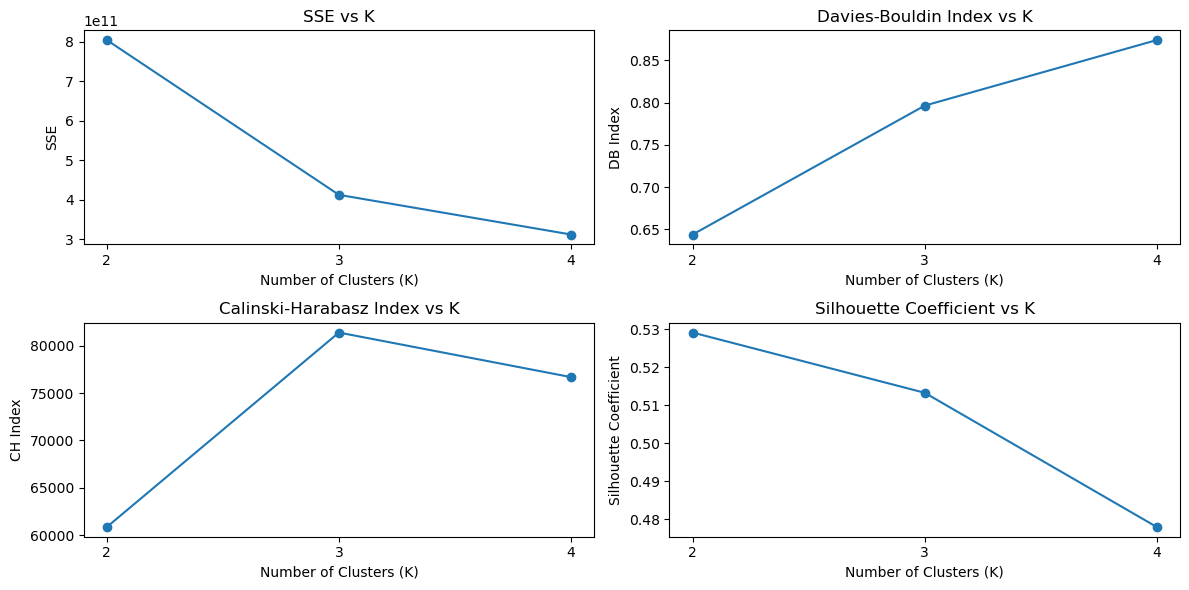

In [4]:
# 提取训练好的模型
extracted_model = ExtractedAutoEncoder(autoencoder, num_layers).to(device)
extracted_output = extracted_model(train_data)   # 形状是[N', T, H]的，要转为[N, H]
extracted_output = extracted_output.view(-1, hidden_dimension)



# 进行K-means聚类分析
kmeans_input = extracted_output.cpu().detach().numpy()
sse_list = []
db_list = []
ch_list = []
sil_list = []
k_values = range(2, 5)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(kmeans_input)
    
    #计算评价指标
    sse = kmeans.inertia_
    silhouette_avg = silhouette_score(kmeans_input, clusters)  # Silhouette Score
    ch_score = calinski_harabasz_score(kmeans_input, clusters)  # Calinski-Harabasz Index
    db_score = davies_bouldin_score(kmeans_input, clusters)  # Davies-Bouldin Index
    
    # 存储结果
    sse_list.append(sse)
    db_list.append(db_score)
    ch_list.append(ch_score)
    sil_list.append(silhouette_avg)
    
    
    # 可视化
    pca = PCA(n_components=2)
    kmeans_output_2d = pca.fit_transform(kmeans_input)

    df = pd.DataFrame(data=kmeans_output_2d, columns=['Component 1', 'Component 2'])
    df['Cluster'] = clusters

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='Cluster', palette='deep', s=100)
    plt.title(f'K-means Clustering Results (K={k})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()
    
    
# 绘制曲线图
plt.figure(figsize=(12, 6))

# SSE ，越低越好
plt.subplot(2, 2, 1)
plt.plot(k_values, sse_list, marker='o')
plt.title('SSE vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.xticks(k_values)

# DB 曲线，越低越好
plt.subplot(2, 2, 2)
plt.plot(k_values, db_list, marker='o')
plt.title('Davies-Bouldin Index vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('DB Index')
plt.xticks(k_values)

# CH 曲线，越大越好
plt.subplot(2, 2, 3)
plt.plot(k_values, ch_list, marker='o')
plt.title('Calinski-Harabasz Index vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('CH Index')
plt.xticks(k_values)


# 轮廓系数曲线,越大越好
plt.subplot(2, 2, 4)
plt.plot(k_values, sil_list, marker='o')
plt.title('Silhouette Coefficient vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Coefficient')
plt.xticks(k_values)

plt.tight_layout()
plt.show()
